In [1]:
import pandas as pd
import requests
import gdelt

gd = gdelt.gdelt(version=2)

events = gd.Search(date=['2017 28 May','2017 29 May'],table='events',coverage=True,output='gpd',normcols=True)


/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/gdelt/parallel.py:66: UserWarning: GDELT does not have a url for date time 20170529004500
  warnings.warn(message)
/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/gdelt/parallel.py:99: UserWarning: GDELT did not return data for date time 20170529004500
  warnings.warn(message)
/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/gdelt/parallel.py:66: UserWarning: GDELT does not have a url for date time 20170529023000
  warnings.warn(message)
/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/gdelt/parallel.py:99: UserWarning: GDELT did not return data for date time 20170529023000
  warnings.warn(message)
/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/gdelt/parallel.py:66: UserWarning: GDELT does not have a url for date time 20170529030000
  warnings.warn(message)
/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/gdelt/parallel.py:99: UserWarning: GDELT 

In [16]:
events.columns

Index(['globaleventid', 'sqldate', 'monthyear', 'year', 'fractiondate',
       'actor1code', 'actor1name', 'actor1countrycode', 'actor1knowngroupcode',
       'actor1ethniccode', 'actor1religion1code', 'actor1religion2code',
       'actor1type1code', 'actor1type2code', 'actor1type3code', 'actor2code',
       'actor2name', 'actor2countrycode', 'actor2knowngroupcode',
       'actor2ethniccode', 'actor2religion1code', 'actor2religion2code',
       'actor2type1code', 'actor2type2code', 'actor2type3code', 'isrootevent',
       'eventcode', 'cameocodedescription', 'eventbasecode', 'eventrootcode',
       'quadclass', 'goldsteinscale', 'nummentions', 'numsources',
       'numarticles', 'avgtone', 'actor1geotype', 'actor1geofullname',
       'actor1geocountrycode', 'actor1geoadm1code', 'actor1geoadm2code',
       'actor1geolat', 'actor1geolong', 'actor1geofeatureid', 'actor2geotype',
       'actor2geofullname', 'actor2geocountrycode', 'actor2geoadm1code',
       'actor2geoadm2code', 'actor2geo

In [109]:
# %load /Users/linwood/projects/Blogs/drafts/geolocated_social_transcends_political_barriers/notebook/utilities.py
# Author: Linwood Creekmore III
# email: valinvescap@gmail.com
# Custom functions for Twitter Geospatial Analysis Blog


#################################
# Imports
#################################  

import matplotlib.pyplot as plt
import io, json, re, itertools
from functools import partial
from tzwhere import tzwhere
import geoplot.crs as gcrs
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np
import requests
import shapely
import fiona
import gdal
import fiona
import uuid 
import pytz
import os


try:
    from shapely.geometry import Point
    tz1 = tzwhere.tzwhere(shapely=True,forceTZ=True)
except:
    tz2 = tzwhere.tzwhere()
    
try:
    import datashader as ds
    from datashader.utils import export_image
    from datashader import transfer_functions as tf
except:
    print('You do not have datashader installed. You will not be able to plot large data sets.')




#shameless copy paste from json/decoder.py
FLAGS = re.VERBOSE | re.MULTILINE | re.DOTALL
WHITESPACE = re.compile(r'[ \t\n\r]*', FLAGS)

class ConcatJSONDecoder(json.JSONDecoder):
    def decode(self, s, _w=WHITESPACE.match):
        s_len = len(s)

        objs = []
        end = 0
        while end != s_len:
            obj, end = self.raw_decode(s, idx=_w(s, end).end())
            end = _w(s, end).end()
            objs.append(obj)
        return objs

    
#################################
# Converts tweet json into tidy data
#################################    

def reader(filename,anonymize=True):
    """Transform tweet json data into tidy format.
    
    This function transforms tweets into tidy format.
    This has been tested and workds on Assumes you are retrieving 
    tweets from the Twitter API. *Requires pandas library.*

    Parameters
    ----------
    filename : str
        string representing path to twitter data in json format.
    
    Returns
    -------
    dataframe
        Pandas dataframe in tidy format.
    """
    try:
        df = pd.read_json(filename, convert_dates=True) # try to read in normally
        "contributers" in df.columns # look for column
    except:
        # trying to read in jsons with "trailing data"
        with open(filename,'rb') as f:
            g=io.StringIO(f.read().decode('utf-8'))
            h = json.load(g,cls=ConcatJSONDecoder)
            if len(h)>1 and len(h)<1000:   
                try:
                    
                    df = pd.DataFrame(list(itertools.chain(*h)))
                    df = df.assign(created_at=pd.to_datetime(df.created_at))
                except:
                    df = pd.DataFrame(h)
                    df = df.assign(created_at=pd.to_datetime(df.created_at))
            else:
                # trying to read in jsons that return as two lists of dicts
                df = pd.read_json(io.StringIO(json.dumps(h)),convert_dates=True)
                try:
                    # reading another dirty version
                    df = df.apply(lambda x: pd.Series(json.loads(x[0])),axis=1)
                except:
                    # return to original if nothing workds
                    df = df
    df.dropna(subset=['coordinates', 'created_at'], how='all',inplace=True) # drop rows with NA
    df.reset_index(inplace=True,drop=True) # reset the index
    df.set_index('created_at', drop=True,inplace=True)
    dfsmall = df[[u'coordinates', u'lang', u'text']].assign(
        screenname = df.apply(
            lambda x: x['user']['screen_name'], axis=1),
        urls=df.apply(
            lambda x: x['entities']['urls'][0]['expanded_url'] \
            if len(x['entities']['urls']) != 0 else None,
            axis=1),
        tweetid = df.apply(lambda x: x['id'], axis=1),
        latitude = df.apply(
            lambda x: (x['coordinates']['coordinates'][1]\
            if isinstance(x['coordinates'], dict) == True else None),
            axis=1),
        longitude = df.apply(
            lambda x: (x['coordinates']['coordinates'][0]\
            if isinstance(x['coordinates'], dict) == True else None),
            axis=1),
        type=df.apply(
            lambda x: (x['coordinates']['type']\
            if isinstance(x['coordinates'], dict) == True else None),
            axis=1)).drop(
            labels='coordinates', axis=1)
    del df
    if anonymize:
        dfsmall.drop(['screenname','text','tweetid','urls'],axis=1,inplace=True)
    return dfsmall

#################################
# Highlights dataframe values
#################################

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    top10=['China','United States','India','Russia','Indonesia','Japan','China','Brazil','United Kingdom','Mexico','Russia','Phillipines','Spain']
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

from collections import OrderedDict

#################################
# Identifies primary language
# using custom rules/stats
#################################

def languageweighter(row):
    """Normalizes languages to identify true primary langauge.
    
    Weighting function to identify the true primary language
    of a region.  Uses rule to identify a count of occurences
    per country.  If the highest proportional language is 
    English and a second langauge contributes 10% or more, this
    function weights the second language as the primary, and reverses
    the proportion to a 25/75 split, where the second language will 
    account for a larger proportion.  
    
    Parameters
    ----------
    row : pandas row
        performs weighting on pandas row in vectorized operations
    
    Returns
    -------
    row
        row with weighted/transformed language proportions.
    """
    
    ratio = row.sort_values(ascending=False)/\
        row.sort_values(ascending=False).sum()
    old0,old1,old2 = ratio[0],ratio[1],ratio[2]
    try:
        if ratio.index[0]=='en' and ratio[1]>=0.10:
            ratio[0]=((old0+old1)*.25)
            ratio[1]=((old0+old1)*.75)
        elif ratio.index[0]=='en' & ratio[1]>0.10 and ratio[2]>0.03:
            ratio[0]=((old0+old1)*.05)
            ratio[1]=((old0+old1)*.65)
            ratio[2]=((old0+old1)*.25)       
    except:
        ratio=ratio
    return ratio

#################################
# Creates shapely points
#################################

def shaper(row):
    """
    Parallel function to create shapely points
    from latitude/longitude pair in dataframe
    
    Parameters
    ----------
    row : pandas or dask dataframe row
        Row containing latitude and longitude variables and data
    
    Returns
    -------
    shapely point
        Shapely spatial object for geoprocessing in Python.
    """
    geometry=Point(row['longitude'],row['latitude'])
    return geometry

def show_function(function):
    """
    Utility function to load function into
    jupyter notebook for review.
    
    Parameters
    ----------
    function : function that is active/imported
        Function must be imported to work
    
    Returns
    -------
    function string
        Loads full function logic into ipython cell.
    """
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))
    
def timenormalize(frame,date_column='created_at'):
    """
    Function to take column of dataframe dates and 
    normalize to local time
    
    Parameters
    ----------
    frame : pandas, geopandas or dask dataframe
        Frame with a datetime column
        
    date_column : string
        String name of the column with the datetime objects
    
    Returns
    -------
    Series
        Series/column with normalized datetime objects at 
        local time
    """
    
       
    # convert to datetime object with UTC time tag
    now_aware = pytz.utc.localize(frame[date_column].to_pydatetime())
    
    # get the timezone string representation using lat/lon pair
    try:
        timezone_str=tz1.tzNameAt(frame['latitude'],frame['longitude'],forceTZ=True)
    except:
        try:
            timezone_str=tz2.tzNameAt(frame['latitude'],frame['longitude'],forceTZ=True)
        except Exception as e:
            raise('You need to install the pytzwhere module.  {0}'.format(e))
             
    
    # get the time offset
    timezone = pytz.timezone(timezone_str)
    
    # convert UTC to calculated local time
    aware = now_aware.astimezone(timezone)
    
    return aware


def call_apply_fn(df,function=None):
    """Small utility function to apply parallel functions to dataframe
    """
    if function:
        return df.apply(function, axis=1)
    else:
        raise('You need to enter a function to vectorize')

       
        
def shapefilereader(target):
    """Function to convert zipped shapefiles from the web or on disk into geopandas dataframes
    
    Parameters
    ----------
    target : str
        string representing path to file on disk or url to download the zipped shapefile.
    
    Returns
    -------
    Geopandas dataframe
        Pandas dataframe with geospatial features and operations.
    
    """
    
    # Detect whether we are using a web-based shapefile or local disk
    r = re.compile('^(http|https)://',re.I)
    if r.search(target):
        download = True
        request = requests.get(target)
        target = '/vsimem/{}.zip'.format(uuid.uuid4().hex) #gdal/ogr requires a .zip extension
        gdal.FileFromMemBuffer(target,bytes(request.content))
    else:
        download = False
    
    
    with fiona.Collection(target,vsi='zip') as f:
        return gpd.GeoDataFrame.from_features(f,crs=f.crs)
    

def coordgetter(row):
    """Converts latitude and longitude"""
    geometry= Point(row['longitude'],row['latitude'])
    try:
        name = row['NAME']
    except:
        name = row['name']
    b = pd. Series({'lang':row['lang'],'name':name,
                   'created_at':row['created_at'],'geometry':geometry,})
    return b
    
def pointgetter(row):
    longitude=row['geometry'].x
    latitude=row['geometry'].y
    
    b = pd.Series({'latitude':latitude,'longitude':longitude})
    
    return b

def gpdmaker(frame):
    return gpd.GeoDataFrame(frame,crs={'init':'epsg:4326'}).to_crs({'init':'epsg:3857'})

def continentlabs(row):
    shape = row['geometry'].centroid
    x,y = shape.x,shape.y
    return (x,y,row['name'])


def datshadeit(frame,col_key=None,method='log',exportit=False,column=None, path=None):
    """Takes Dataframe with web mercator projection columns of "latitude" and "longitude"
    and plots using datashader.  Can handle millions or billions of points
    
    Parameters
    ----------
    
    frame : geopandas or pandas dataframe
        Dataframe containing the longitude and latitude columns. Must be web mercator
        projection.
    
    col_key : dictonary 
        Dictionary holding key/value store of categories and colors.  If you want to 
        plot different categories, this is required.  Number of colors must match
        the number of categories.
    
    method : string, Default = 'log' , Optional = 'cbrt','linear','eq_hist'
        Datashader interpolization options. Choose from options listed above.
        
    exportit: Boolean
        Decide whether to export the image to disk.
    
    column : string
        The categorical column to count and color on.  Requires color key.
        
    path : string
        Path where the image will be stored if you decide to export.
    """

    background='black'
    export = partial(export_image, export_path="export", background=background)

    bound = 20026376.39
    bounds = dict(x_range = (-bound, bound), y_range = (int(-bound*0.4), int(bound*0.6)))
    plot_width = 1000
    plot_height = int(plot_width*0.5)


    x_range = (-bound, bound)
    y_range = (int(-bound*0.4), int(bound*0.6))

    cvs = ds.Canvas(plot_width=1050, plot_height=650, x_range=x_range, y_range=y_range)
    if column:
        agg = cvs.points(frame, 'longitude', 'latitude',ds.count_cat(column))
    else:
        agg = cvs.points(frame, 'longitude', 'latitude')
        
    tf.warnings.filterwarnings('ignore')

    img = tf.shade(agg,color_key=col_key ,how=method)
    if not path:
        path = os.getcwd()
    if exportit:
        return export_image(img,path,background='black')
    return img



def kernelde(datframe,polyframe,samplenum=500,path=None):
    samp = datframe.sample(samplenum)
    ax = gplt.polyplot(polyframe,projection=gcrs.PlateCarree(),figsize=(20,12))
    gplt.kdeplot(samp,ax=ax,shade=True,shade_lowest=False,projection=gcrs.TransverseMercator())
    
    if not path:
        path = os.getcwd()
    plt.savefig(path)
    plt.show()

/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


You do not have datashader installed. You will not be able to plot large data sets.


/Users/linwood/anaconda3/envs/myenv/lib/python3.5/site-packages/dask/dataframe/hashing.py:8: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import is_bool_array


In [110]:
world = shapefilereader('http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip')

In [121]:
(events[(events.actiongeotype==3)| (events.actiongeotype==4)]\
.groupby(['actiongeofeatureid','eventcode','actiongeofullname','actiongeocountrycode'])\
             .size().sort_values(ascending=False).reset_index())\
.rename(columns={0:"reportcount"})

,actiongeofeatureid,eventcode,actiongeofullname,actiongeocountrycode,reportcount
0,531871,042,"Washington, District of Columbia, United States",US,421
1,531871,040,"Washington, District of Columbia, United States",US,400
2,531871,043,"Washington, District of Columbia, United States",US,385
3,531871,040,"White House, District of Columbia, United States",US,355
4,531871,010,"Washington, District of Columbia, United States",US,336
5,-2960561,040,"Moscow, Moskva, Russia",RS,328
6,-1746443,036,"Berlin, Berlin, Germany",GM,324
7,531871,042,"White House, District of Columbia, United States",US,319
8,-2438515,190,"Marawi, Marawi, Philippines",RP,309
9,531871,010,"White House, District of Columbia, United States",US,300


In [68]:
from pandas.io import gbq
q="""
SELECT SQLDATE,SOURCEURL,GLOBALEVENTID,DATEADDED,EventCode,Actor1Code,Actor1Name,Actor2Code,Actor2Name,ActionGeo_Long,ActionGeo_Lat,GoldsteinScale,ActionGeo_FeatureID
FROM [gdelt-bq:full.events] 
WHERE (EventCode = '1831' AND ActionGeo_FeatureID='-2602512');
"""


# run the query
df4 = gbq.read_gbq(q, project_id='drivepython-150614')

Requesting query... ok.
Query running...
Query done.
Processed: 61.3 GB

Retrieving results...
Got 567 rows.

Total time taken 2.78 s.
Finished at 2017-05-31 07:57:36.


In [80]:
import datetime
from dateutil.parser import parse
# pd.to_datetime(df4.apply(lambda x: datetime.datetime(x,)))
df5 = df4.set_index(df4.DATEADDED.apply(lambda x: parse(str(x)))).sort_index()

In [106]:
df5.shape

(567, 13)

(722450.0, 736845.0)

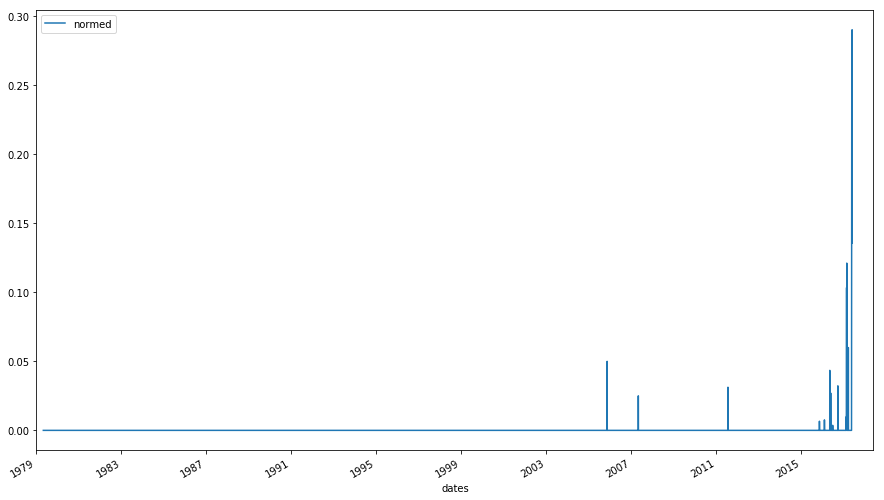

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

fig,ax=plt.subplots()
df2 = df2.assign(normed=df2.c_up/df2.c,dates=df2.SQLDATE.apply(lambda x: datetime.datetime.strptime(str(x),"%Y%m%d")))
df2.plot(ax=ax,figsize=(15,9),y='normed',x='dates')
ax.set_xlim(pd.Timestamp('1979-01-01'), pd.Timestamp('2018-05-31'))

In [26]:
!/Users/linwood/anaconda3/envs/myenv/bin/pip install pandas-gbq

In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
ethnic='https://raw.githubusercontent.com/openeventdata/Dictionaries/master/CAMEO.EthnicGroups.actors.txt'
religious = 'https://raw.githubusercontent.com/openeventdata/Dictionaries/master/CAMEO.ReligiousGroups.actors.txt' 
nonstateactors='https://raw.githubusercontent.com/openeventdata/Dictionaries/master/Phoenix.MilNonState.actors.txt'
governments='https://github.com/openeventdata/Dictionaries/blob/master/Phoenix.Countries.actors.txt?raw=true'
internationalactors='https://raw.githubusercontent.com/openeventdata/petrarch/master/petrarch/data/dictionaries/Phoenix.International.actors.txt'
import pandas as pd
table = internationalactors
if table==governments:
    skipper=43
elif table == ethnic:
    skipper=11
elif table == nonstateactors:
    skipper=14
elif table == religious:
    skipper=10  
elif table == internationalactors:
    skipper=19
 
test = pd.read_table(table,skiprows=skipper,names=['codes'])

test

In [1]:
import csv

In [22]:
import re
p = re.compile('^(#+)')
n = re.compile('^[A-Za-z]')
r = re.compile('^(\++)')
s = re.compile('^\[')


In [46]:
import string
count = 0
lens = []
name = None
alternates = None
code = None
with open('international.csv') as f:
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if len(row)==0 or p.search(row[0]):
            pass
        elif len(row)==1:
            if n.search(row[0]):
                name = row[0]
#                 print(f"The name is {name}")
            elif r.search(row[0]):
                if alternates:
                    alt = row[0]
                    alternates+=f"; {alt}"
                else:
                    alternates=row[0]
#                 print(f"The alternate is {alternates}")
        elif len(row)>=2:
            trans_table = str.maketrans({'[': '', ']': ''})
            code = row[1].split(" ")[0].translate(trans_table)
        if code and name:
            print(f"The code is {code}; the name is {name}; and the other names are {alternates}")
            code,name,alternates=None,None,None
#         else:
#             if len(row)==1:
#                 if p.search(row[0]):
#                     pass
#                 elif n.search(row[0]):
#                     name=row[0]
#                     if len(val)>0:
#                         if len(values)==0:
#                             values+=val
#                         else:
#                             values+=f";{val}"
#             elif len(row)>=2:
#                 if s.search(row[1]):
#                     trans_table = str.maketrans({'[': '', ']': ''})
                    
#                     code=(row[1].translate(trans_table)).split(';')
# #                 print (row)
#         print(name)
#         values=""
#         code=""
#         name=""
        
#         if count >=1000:
#             break
#         else:
            
                
                
# #             print(" ".join(row).split('\t'))
#             print (len(row))
# #             print (row,len(row))
#             count += 1
# #             if r.search(row):
# #                 pass
# #             else:
# #                 print (row)
# #                 count += 1


The code is IGOUNO; the name is U.N._; and the other names are None
The code is IGOUNO; the name is UN_SECRETARY_GENERAL; and the other names are +SECRETARY_GENERAL_OF_THE_UNITED_NATIONS_; +SECRETARY_GENERAL_OF_THE_UN; +UN_Secy_Gen; +U.N._SECRETARY_GENERAL; +UN_SEC._GEN; +UNITED_NATIONS_CHIEF; +UNSG
The code is IGOUNO; the name is SECRETARY-GENERAL_BAN_KI-MOON; and the other names are +UN_SECRETARY-GENERAL_BAN_KI-MOON; +UNITED_NATIONS_SECRETARY_GENERAL_BAN_KI-MOON; +UNITED_NATIONS_SECRETARY-GENERAL_BAN_KI-MOON; +BAN_KI-MOON
The code is ELI;; the name is BOUTROS_BOUTROS_GHALI_; and the other names are +SECRETARY-GENERAL_KOFI_ANNAN; +UNITED_NATIONS_SECRETARY_GENERAL_KOFI_ANNAN; +SECRETARY-GENERAL_KOFI_ANNAN; +K._ANNAN_; +K_ANNAN_; +KOFI_ATTA_ANNAN_
The code is ELI;; the name is ABRAHAM_ABRAHAM_; and the other names are +BOUTROS_BOUTROS-GHALI_; +SECRETARY-GENERAL_BOUTROS-GHALI_; +UNITED_NATIONS_SECRETARY_GENERAL_BOUTROS-GHALI_; +SECRETARY-GENERAL_BOUTROS-GHALI_
The code is IGOUNOREFHCR; t

In [2]:
!pwd

/Users/linwood/projects/gdeltPyR/notebook


ModuleNotFoundError: No module named '__main__.gdelt'; '__main__' is not a package

In [12]:
import numpy as np
from dateutil.parser import parse
dateString = ['20160505', '20160507', '20160506']

if not (np.all(list(
        map(
            lambda x: x > parse('2013 04 01'), list(
                map(
                    parse, dateString)))))):

    answer= (list(
        map(lambda x: base + x + ".zip" if parse(
            x).date() < parse(
            '2013 04 01').date() else base + x + caboose,
            dateString)))

In [15]:
(np.all(list(
        map(
            lambda x: x > parse('2013 04 01'), list(
                map(
                    parse, dateString))))))

True

In [28]:
import requests
import pandas as pd
import io

r = requests.get('http://data.gdeltproject.org/gdeltv2_cloudvision/20170528021500.imagetags.csv.gz')

data = io.BytesIO(r.content)

df = pd.read_csv(data,compression='gzip',sep='\t',header=None)

In [9]:
d ='''GKGRECORDID	STRING	NULLABLE	
Describe this field...
DATE	INTEGER	NULLABLE	
Describe this field...
SourceCollectionIdentifier	INTEGER	NULLABLE	
Describe this field...
SourceCommonName	STRING	NULLABLE	
Describe this field...
DocumentIdentifier	STRING	NULLABLE	
Describe this field...
Counts	STRING	NULLABLE	
Describe this field...
V2Counts	STRING	NULLABLE	
Describe this field...
Themes	STRING	NULLABLE	
Describe this field...
V2Themes	STRING	NULLABLE	
Describe this field...
Locations	STRING	NULLABLE	
Describe this field...
V2Locations	STRING	NULLABLE	
Describe this field...
Persons	STRING	NULLABLE	
Describe this field...
V2Persons	STRING	NULLABLE	
Describe this field...
Organizations	STRING	NULLABLE	
Describe this field...
V2Organizations	STRING	NULLABLE	
Describe this field...
V2Tone	STRING	NULLABLE	
Describe this field...
Dates	STRING	NULLABLE	
Describe this field...
GCAM	STRING	NULLABLE	
Describe this field...
SharingImage	STRING	NULLABLE	
Describe this field...
RelatedImages	STRING	NULLABLE	
Describe this field...
SocialImageEmbeds	STRING	NULLABLE	
Describe this field...
SocialVideoEmbeds	STRING	NULLABLE	
Describe this field...
Quotations	STRING	NULLABLE	
Describe this field...
AllNames	STRING	NULLABLE	
Describe this field...
Amounts	STRING	NULLABLE	
Describe this field...
TranslationInfo	STRING	NULLABLE	
Describe this field...
Extras	STRING	NULLABLE	
Describe this field...'''

In [25]:
import csv
for l in d.strip().split('\n'):
    print (", ".join(l.strip(" ").split()))
    break
# with open('iatvheaders.csv','wb') as f:
#     spamwriter = csv.writer(delimiter=',')

    

GKGRECORDID, STRING, NULLABLE


In [36]:
df.ix[24][11]

'{ "responses": [ { "labelAnnotations": [ { "mid": "/m/07bsy", "description": "transport", "score": 0.87030876 }, { "mid": "/m/0k4j", "description": "car", "score": 0.8695595 }, { "mid": "/m/079bkr", "description": "mode of transport", "score": 0.8423645 }, { "mid": "/m/0btp2", "description": "traffic", "score": 0.8193224 }, { "mid": "/m/0h8ls87", "description": "automotive exterior", "score": 0.74120593 }, { "mid": "/m/05ws7", "description": "police", "score": 0.7256743 }, { "mid": "/m/07yv9", "description": "vehicle", "score": 0.67235726 }, { "mid": "/m/04qvtq", "description": "police car", "score": 0.6050917 }, { "mid": "/m/01j0ry", "description": "traffic congestion", "score": 0.5916241 }, { "mid": "/m/0kw6d", "description": "driving", "score": 0.55533457 }, { "mid": "/m/01jp76", "description": "parking", "score": 0.5476788 }, { "mid": "/m/05zdp", "description": "public transport", "score": 0.524665 } ], "textAnnotations": [ { "locale": "en", "description": "STOP\\n", "boundingPoly

In [35]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,20170528013000,http://giaoduc.net.vn/Giao-duc-24h/Tac-dong-cu...,http://img.giaoduc.net.vn/Uploaded/vuongthuy/2...,public speaking<FIELD>0.9559472<FIELD>/m/068k4...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,0.99853504<FIELD>-7.678266<FIELD>-28.742496<FI...,NaN,"zh-CN,en,zh-TW,vi","562,374","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
1,20170528013000,http://giaoduc.net.vn/Giao-duc-24h/Tac-dong-cu...,http://img.giaoduc.net.vn/w500/Uploaded/vuongt...,public speaking<FIELD>0.95897806<FIELD>/m/068k...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,0.99647635<FIELD>-7.78043<FIELD>-29.168629<FIE...,NaN,"zh-CN,en,zh-TW,vi","500,333","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
2,20170528013000,http://www.ole.com.ar/futbol-primera/Huracan-B...,http://www.ole.com.ar/futbol-primera/fotos-Hur...,player<FIELD>0.94173044<FIELD>/m/02vzx9<RECORD...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,NaN,BBVA\nBBNA BB\nBBVA\n<RECORD>BBVA<RECORD>BBNA<...,"en,es,sr","660,385","{ ""responses"": [ { ""labelAnnotations"": [ { ""mi..."
3,20170528013000,http://www.horacero.com.mx/nacional/cns-analiz...,http://www.horacero.com.mx/wp-content/uploads/...,person<FIELD>0.8971223<FIELD>/m/01g317<RECORD>...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,0.5939891<FIELD>11.807354<FIELD>-55.88877<FIEL...,NaN,"en,es","1098,697","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
4,20170528013000,http://www.yenisafak.com/gundem/ilk-iftari-coc...,http://yenisafak.feo.doracdn.com/resize/47uQuf...,lunch<FIELD>0.8349762<FIELD>/m/0jfd5<RECORD>me...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,0.8702682<FIELD>6.4371424<FIELD>49.38917<FIELD...,NaN,"en,tr","600,336","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
5,20170528013000,http://www.yenisafak.com/gundem/ilk-iftari-coc...,http://yenisafak.feo.doracdn.com/resize/47uQuf...,lunch<FIELD>0.8054063<FIELD>/m/0jfd5<RECORD>me...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,0.64316535<FIELD>6.295055<FIELD>48.02636<FIELD...,NaN,"en,tr","480,269","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
6,20170528013000,http://fenix951.com.ar/nuevo_2013/noticia.php?...,http://www.fenix951.com.ar/nuevo_2013/imagenes...,hair<FIELD>0.97114366<FIELD>/m/03q69<RECORD>hu...,NaN,NaN,0<FIELD>-1<FIELD>0<FIELD>0.5,0.90507096<FIELD>-3.0112946<FIELD>13.699397<FI...,o\na a\n<RECORD>o<RECORD>a<RECORD>a,"en,es","760,450","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
7,20170528013000,http://www.vanguardia.com.mx/articulo/un-polic...,http://image.vanguardia.com.mx/sites/default/f...,police<FIELD>0.83474565<FIELD>/m/05ws7<RECORD>...,NaN,Policia Federal<FIELD>0.20523158<FIELD>/g/1ptx...,0<FIELD>0<FIELD>0<FIELD>0,0.51180035<FIELD>-1.8241434<FIELD>14.286311<FI...,POLICIA FEDERAL\n14834\nPOLICIA\n14834\nSSP\nP...,"en,es","2048,1360","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
8,20170528013000,http://www.aleqtisady.com/world/tw-885162,http://www.aleqtisady.com/temp/resized/medium_...,person<FIELD>0.92755556<FIELD>/m/01g317<RECORD...,NaN,NaN,0<FIELD>0<FIELD>0<FIELD>0,0.9317069<FIELD>5.359557<FIELD>15.516358<FIELD...,NaN,"en,ar","700,450","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
9,20170528013000,http://www.vanguardia.com.mx/articulo/un-polic...,http://image.vanguardia.com.mx/sites/default/f...,police<FIELD>0.82246053<FIELD>/m/05ws7<RECORD>...,NaN,Policia Federal<FIELD>0.20459506<FIELD>/g/1ptx...,0<FIELD>0<FIELD>0<FIELD>0,0.5139322<FIELD>-2.3561645<FIELD>14.886037<FIE...,POLICIA FEDERAL\n14834\nPOLICIA\nPOLICIA\n<REC...,"en,es","2048,1360","{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
